In [2]:
"""\
# Copyright (C) 2023 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 --version

Python 3.10.12


In [16]:
import os
import pandas as pd
import numpy as np

# Graphic tool
import matplotlib.pyplot as plt

DATA_PATH = os.path.join("data")

In [32]:
def load_data(filename, t0, tf=None):
    """
    Load Paparazzi .csv data files
    """
    data = pd.read_csv(os.path.join(DATA_PATH, filename), sep="\t")
    if tf is None:
        data = data.loc[(data["Time"] >= t0)]
    else:
        data = data.loc[(data["Time"] >= t0) & (data["Time"] <= tf)]
    return data

## Read the logs

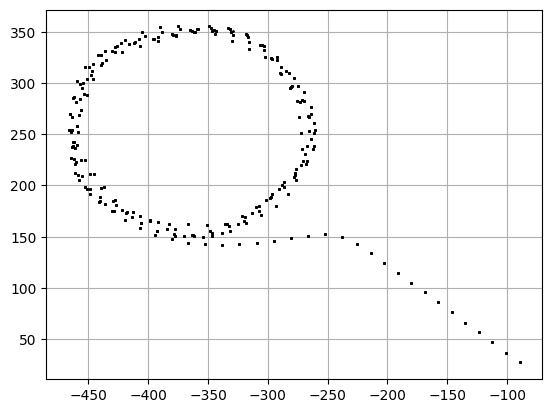

In [56]:
plt.plot(data_x, data_y, ".k", markersize=2)
plt.grid(True)

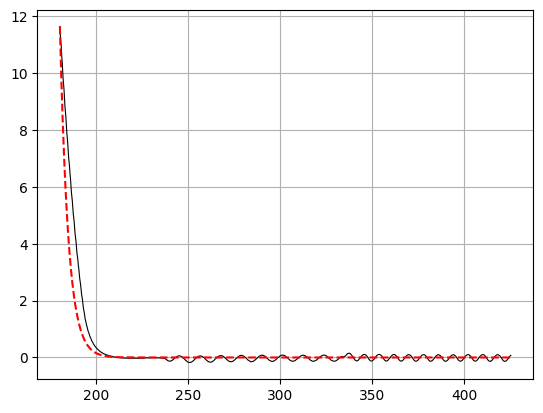

In [57]:
ke = 0.22
t0 = data_time[0]
phi0 = data_phi[0]

plt.plot(data_time, data_phi, "-k", markersize=2, lw=0.8)
plt.plot(data_time, phi0*np.exp(-ke*(data_time - t0)), "--r")
plt.grid(True)

## Generate the article plots

In [134]:
def vector2d(
        ax, 
        P0, Pf, 
        c="k", ls="-", s=1, lw=0.7, hw=0.1, hl=0.2, alpha=1, zorder=1):
    """
    Function to easy plot a 2D vector
    """
    quiv = ax.arrow(
        P0[0],
        P0[1],
        s * Pf[0],
        s * Pf[1],
        lw=lw,
        color=c,
        ls=ls,
        head_width=hw,
        head_length=hl,
        length_includes_head=True,
        alpha=alpha,
        zorder=zorder,
    )
    return quiv

class GVF_IK_exp1:
    def __init__(self, data, ke, t0_cond):
        # Procressing the data
        self.data_time = np.array(data["Time"].to_list())
        self.data_x = np.array(data["NAVIGATION:pos_x"].to_list())
        self.data_y = np.array(data["NAVIGATION:pos_y"].to_list())
        self.data_phi = np.array(data["GVF:phi"].to_list())
        self.data_omega_d = np.array(data["GVF:omega_d"].to_list())
        self.data_omega = np.array(data["GVF:omega"].to_list())
        self.data_n_norm = np.array(data["GVF:n_norm"].to_list())
        self.data_t_norm = np.array(data["GVF:t_norm"].to_list())

        self.ke = ke

        self.data_time = self.data_time - self.data_time[0]

        self.t0 = t0_cond
        self.phi0 = self.data_phi[self.data_time < self.t0][-1]

    def plot(
            self, 
            dpi=100, 
            figsize=(14,8), 
            xlim=None, 
            ylim=None,
            fontsize=12
            ):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)
        ax = fig.add_subplot(grid[:, 0:2])
        axr1 = fig.add_subplot(grid[0, 2:4])
        axr2 = fig.add_subplot(grid[1, 2:4])
        axr3 = fig.add_subplot(grid[2, 2:4])

        # Axis configuration
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        ax.set_xlabel("X [L]")
        ax.set_ylabel("Y [L]")
        ax.set_aspect("equal")

        # Right axis configuration
        axr1.set_ylabel(r"$\phi$")
        axr1.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr1.yaxis.tick_right()
        axr1.grid(True)
        axr2.set_ylabel(r"$\omega$ [rad/s]")
        axr2.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr2.yaxis.tick_right()
        axr2.grid(True)
        axr3.set_ylabel(r"[m/s]")
        axr3.set_xlabel(r"$t$ [s]")
        axr3.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        axr3.yaxis.tick_right()
        axr3.grid(True)

        # Plot: 2D X-Y
        self.data_x
        ax.plot(self.data_x, self.data_y, lw=0.8)
        
        # Plot: phi
        axr1.axhline(0, color="k", ls="-", lw=1)
        axr1.axvline(self.t0, color="k", ls="--", lw=0.8)
        # axr1.axhline(0.1, color="k", ls="--", lw=0.8)
        # axr1.axhline(-0.1, color="k", ls="--", lw=0.8)

        exp_time = self.data_time[self.data_time > self.t0]
        exp_data = self.phi0*np.exp(-self.ke*(exp_time - self.t0))
        axr1.plot(self.data_time, self.data_phi, lw=1.5)
        axr1.plot(exp_time, exp_data, "--r", lw=1.5)


        # Plot: omega plot
        axr2.axhline(0, color="k", ls="-", lw=1)
        axr2.axvline(self.t0, color="k", ls="--", lw=0.8)

        axr2.plot(self.data_time, self.data_omega_d, "r", lw=1.5, label=r"$\omega_d$")
        axr2.plot(self.data_time, self.data_omega, lw=1.5)
        axr2.legend(fancybox=True, prop={"size": 12}, ncols=2)

        # Plot: tangent and normal norms of pd
        axr3.axhline(0, color="k", ls="-", lw=1)
        axr3.axvline(self.t0, color="k", ls="--", lw=0.8)

        axr3.plot(self.data_time, self.data_n_norm, lw=1.5, label=r"$||u_n||$")
        axr3.plot(self.data_time, self.data_t_norm, "r", lw=1.5, label=r"$||u_t||$")
        axr3.legend(fancybox=True, prop={"size": 12}, ncols=2)
        
        # -> Show the plot <-
        ax.grid(True)
        plt.show()

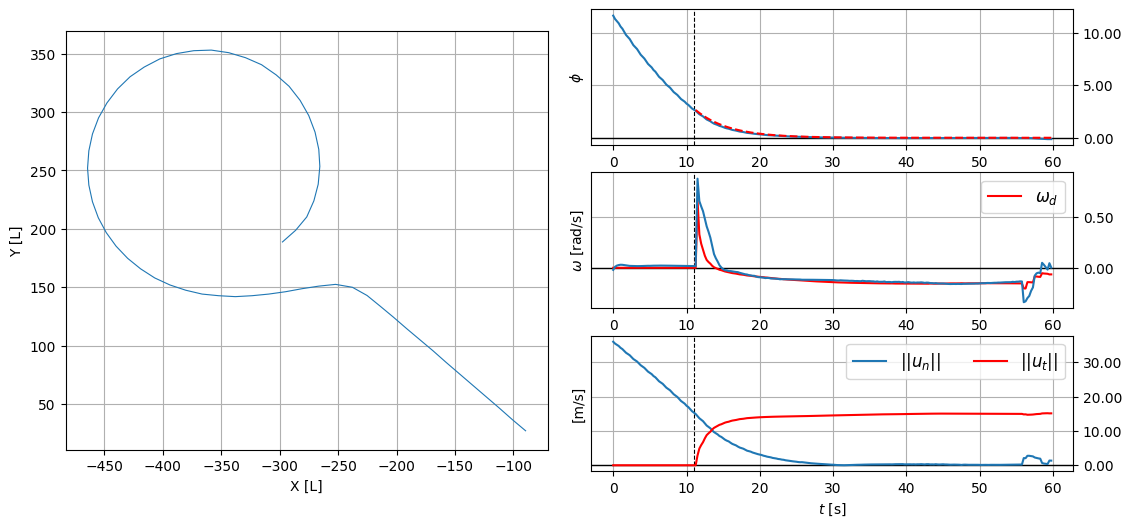

In [135]:
# Loading data
t0, tf = 180, 240
filename = "24_09_09__12_56_10:5.csv" # ke=0.22, kn=1.37

data = load_data(filename, t0, tf)

exp1 = GVF_IK_exp1(data, ke=0.22, t0_cond=11)
exp1.plot(dpi=100, figsize=(13,6))